In [7]:
!sudo apt-get install swig  # swig 설치
!pip install box2d gymnasium[box2d]

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
swig is already the newest version (4.0.2-1ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
!git clone https://github.com/Soggeum/20242R0136COSE47402.git
%cd 20242R0136COSE47402/FinalProject/lunar-lander

Cloning into '20242R0136COSE47402'...
remote: Enumerating objects: 81, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 81 (delta 22), reused 40 (delta 10), pack-reused 0 (from 0)
Receiving objects: 100% (81/81), 15.20 MiB | 13.14 MiB/s, done.
Resolving deltas: 100% (22/22), done.
/content/20242R0136COSE47402/FinalProject/lunar-lander


In [8]:
import gymnasium as gym
import pygame
import numpy as np
import matplotlib.pyplot as plt
import itertools

In [9]:
import agent_class as agent

# Initialize environment and agent

In [10]:
# We first create the environment on which we will later train the agent
env = gym.make('LunarLander-v3')

# We need to know the dimensionality of the state space, as well as how many
# actions are possible
N_actions = env.action_space.n
observation, info = env.reset()
N_state = len(observation)

print('dimension of state space =',N_state)
print('number of actions =',N_actions)

dimension of state space = 8
number of actions = 4


In [11]:
# We create an instance of the agent class.
# At initialization, we need to provide
# - the dimensionality of the state space, as well as
# - the number of possible actions

parameters = {'N_state':N_state, 'N_actions':N_actions}

my_agent = agent.dqn(parameters=parameters)
# to train via the actor-critic algorithm, use this line:
# my_agent = agent.actor_critic(parameters=parameters)

# Train agent

In [12]:
# We train the agent on the LunarLander-v3 environment.
# Setting verbose=True allows us to follow the progress of the training

training_results = my_agent.train(environment=env,
                                verbose=True)

| episode | return          | minimal return      | mean return        |
|         | (this episode)  | (last 20 episodes)  | (last 20 episodes) |
|-----------------------------------------------------------------------
|     100 |      -63.745    |       -333.606      |      -133.189      |
|     200 |     -137.825    |       -247.144      |       -97.487      |
|     300 |      -48.600    |       -399.012      |       -79.365      |
|     400 |       64.748    |       -264.094      |       -57.653      |
|     500 |      -11.198    |       -108.507      |        -5.500      |
|     600 |      -50.319    |       -182.694      |        21.444      |
|     700 |       92.862    |       -234.553      |       -12.551      |
|     800 |      230.056    |        -98.974      |       178.076      |
|     900 |      266.220    |         -7.204      |       208.497      |
|    1000 |      244.970    |       -212.061      |       163.451      |
|    1053 |      201.835    |        200.804      |

In [13]:
# the method my_agent.train() from the previous cell returns a dictionary
# with training stats, namely:
# - duration of each episode during training,
# - return of each episode during training
# - the total number of training epochs at the end of each episode
# - the total number of steps simulated at the end of each episode

training_results.keys()

dict_keys(['episode_durations', 'epsiode_returns', 'n_training_epochs', 'n_steps_simulated', 'training_completed'])

# Plot training stats

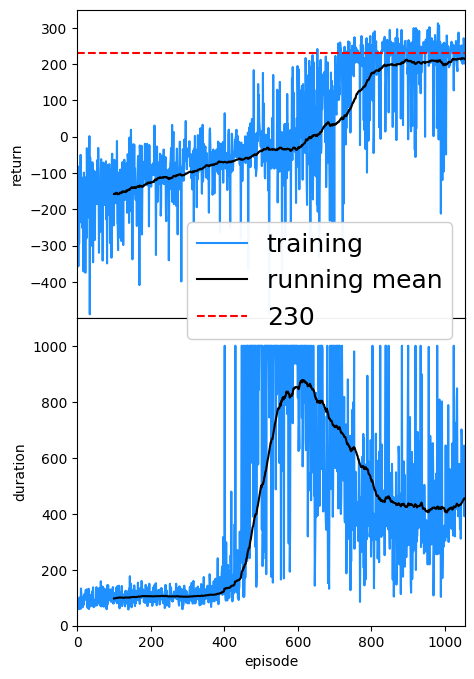

In [14]:
# Plot both the return per episode and the duration per episode during
# training, together with their running average over 20 consecutive episodes

N = 100 # number of episodes for running average

def running_mean(x,N=100):
        x_out = np.zeros(len(x)-N,dtype=float)
        for i in range(len(x)-N):
                x_out[i] = np.mean(x[i:i+N+1])
        return x_out

def plot_returns_and_durations(training_results,filename=None):
    fig,axes = plt.subplots(2,1,figsize=(5,8))
    fig.subplots_adjust(hspace=0.0001)
    #
    # return as a function of episode
    ax = axes[0]
    x = training_results['epsiode_returns']
    t = np.arange(len(x)) + 1
    #
    ax.plot(t,x,label='training',color='dodgerblue',)
    # add running mean
    x = running_mean(x=x,N=N)
    t = np.arange(len(x)) + N
    ax.plot(t,x,color='black',label='running mean')
    #
    ax.axhline(230,ls='--',
               label='230',
                        color='red')
    #
    ax.set_ylim(-499,350)
    ax.set_xticks([])
    ax.set_xlim(0,len(t)+100)
    ax.set_xlabel(r'episode')
    ax.set_ylabel(r'return')
    #
    #
    ax = axes[1]
    x = training_results['episode_durations']
    t = np.arange(len(x)) + 1
    #
    ax.plot(t,x,label='training',color='dodgerblue',)
    # add running mean
    x = running_mean(x=x,N=N)
    t = np.arange(len(x)) + N
    ax.plot(t,x,color='black',label='running mean')
    #
    ax.axhline(1200,ls='--', # draw line outside of plot scale,
                label='230', # to get the red dotted line into the legend
                        color='red')
    #
    ax.set_ylim(0,1100)
    ax.set_xlim(0,len(t)+100)
    ax.set_xlabel(r'episode')
    ax.set_ylabel(r'duration')
    ax.legend(loc='upper right',bbox_to_anchor=(1.,1.35),
                                framealpha=0.95,
                        fontsize=18)
    #
    plt.show()
    if filename != None:
        fig.savefig(filename,bbox_inches='tight')
    plt.close(fig)

plot_returns_and_durations(training_results=training_results)

# Create gameplay video using trained agent

First we create a "live" video that pops up and shows Lunar Lander gameplay performed by the agent

In [15]:
# There is the issue that the game window freezes when running gym games
# in jupyter notebooks, see https://github.com/openai/gym/issues/2433
# We here use the fix from that website, which is to use the following
# wrapper class:
class PyGameWrapper(gym.Wrapper):
    def render(self, **kwargs):
        retval = self.env.render( **kwargs)
        for event in pygame.event.get():
            pass
        return retval

In [16]:
# Create a wrapped environment
env = PyGameWrapper(gym.make('LunarLander-v3',render_mode='human'))

N_episodes = 100

result_string = 'Run {0}: duration = {1}, total return = {2:7.3f}'

for j in range(N_episodes):
    state, info = env.reset()

    total_reward = 0
    for i in itertools.count():
        #env.render()

        action = my_agent.act(state)
        state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        total_reward += reward

        if done:
            print(result_string.format(j+1,i+1,total_reward))
            break

env.close()

Run 1: duration = 248, total return =  14.514
Run 2: duration = 377, total return = 248.985
Run 3: duration = 230, total return = 265.657
Run 4: duration = 369, total return = 191.265
Run 5: duration = 238, total return = 242.310
Run 6: duration = 269, total return = 239.245
Run 7: duration = 323, total return = 248.480
Run 8: duration = 381, total return = 218.104
Run 9: duration = 246, total return = 252.300
Run 10: duration = 470, total return = 221.463
Run 11: duration = 366, total return = 228.637
Run 12: duration = 264, total return = 225.442
Run 13: duration = 412, total return = 236.490
Run 14: duration = 397, total return = 226.231
Run 15: duration = 411, total return = 244.396
Run 16: duration = 277, total return = 256.117
Run 17: duration = 235, total return = 252.910
Run 18: duration = 465, total return = 257.295
Run 19: duration = 294, total return = 259.867
Run 20: duration = 242, total return = 242.040
Run 21: duration = 282, total return = 270.701
Run 22: duration = 318

We also create a video file containing 20 games played by the agent

In [17]:
import gymnasium as gym
from gymnasium.wrappers import RecordEpisodeStatistics, RecordVideo

num_eval_episodes = 100

env = gym.make("LunarLander-v3", render_mode="rgb_array")  # replace with your environment
env = RecordVideo(env, video_folder="my_video", name_prefix="eval",
                  episode_trigger=lambda x: True)

env = RecordEpisodeStatistics(env, buffer_length=num_eval_episodes)

for episode_num in range(num_eval_episodes):
    obs, info = env.reset()

    episode_over = False
    while not episode_over:
        action = my_agent.act(state)
        #action = env.action_space.sample()  # replace with actual agent
        obs, reward, terminated, truncated, info = env.step(action)

        episode_over = terminated or truncated
env.close()

print(f'Episode time taken: {env.time_queue}')
print(f'Episode total rewards: {env.return_queue}')
print(f'Episode lengths: {env.length_queue}')

Episode time taken: deque([0.311925, 0.28265, 0.292123, 0.163196, 0.311078, 0.443475, 0.424414, 0.180685, 0.256797, 0.250661, 0.195404, 0.184452, 0.171173, 0.235925, 0.298416, 0.282709, 0.215556, 0.175997, 0.180359, 0.181282, 0.194256, 0.198976, 0.211736, 0.17581, 0.216039, 0.262194, 0.170621, 0.334554, 0.427533, 0.341296, 0.373633, 0.258384, 0.257188, 0.230793, 0.278835, 0.224457, 0.340175, 0.19485, 0.259501, 0.204033, 0.219903, 0.202196, 0.179451, 0.188532, 0.238245, 0.256306, 0.219375, 0.313412, 0.281403, 0.371024, 0.29449, 0.283219, 0.440799, 0.232745, 0.18972, 0.274274, 0.225524, 0.289379, 0.188666, 0.276966, 0.17473, 0.162626, 0.18886, 0.19861, 0.202365, 0.269546, 0.181188, 0.220788, 0.189535, 0.288949, 0.160587, 0.161592, 0.310657, 0.274798, 0.325157, 0.318655, 0.218424, 0.201108, 0.252109, 0.254843, 0.262852, 0.153719, 0.169261, 0.248311, 0.171791, 0.194068, 0.218216, 0.297351, 0.230847, 0.168986, 0.241275, 0.340926, 0.229671, 0.239674, 0.344907, 0.297843, 0.433897, 0.377388, 0